In [1]:
######### Fake News Detection with Spark, Mlib, NLP, CNN, BERT ##################
# Install necessary libraries
!pip install pyspark findspark tensorflow

import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("FakeNewsDetection") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session created successfully!")


Spark Session created successfully!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# File paths (adjust accordingly)
fake_path = "/content/drive/MyDrive/AIMLBigData/Fake.csv"
true_path = "/content/drive/MyDrive/AIMLBigData/True.csv"

#fake_path = "Fake.csv"
#true_path = "True.csv"

# Load CSVs
df_fake = spark.read.csv(fake_path, header=True, inferSchema=True)
df_true = spark.read.csv(true_path, header=True, inferSchema=True)

print("Fake schema:")
df_fake.printSchema()

print("True schema:")
df_true.printSchema()

Mounted at /content/drive
Fake schema:
root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)

True schema:
root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [3]:
from pyspark.sql.functions import lit

df_fake = df_fake.withColumn("label", lit(1))
df_true = df_true.withColumn("label", lit(0))

df_all = df_fake.unionByName(df_true)
print("Total records:", df_all.count())
df_all.show(5)



Total records: 44906
+--------------------+--------------------+-------+-----------------+-----+
|               title|                text|subject|             date|label|
+--------------------+--------------------+-------+-----------------+-----+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|    1|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|    1|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|    1|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|    1|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|    1|
+--------------------+--------------------+-------+-----------------+-----+
only showing top 5 rows



In [4]:
### Preprocess the new contents ###
from pyspark.sql.functions import concat_ws, lower, regexp_replace, col

# Combine title and text into a single 'content' column
df_all = df_all.withColumn("full_text", concat_ws(" ", col("title"), col("text")))

# Define a common label indexer
label_indexer = StringIndexer(inputCol="label", outputCol="numeric_label")
# Apply the label indexer to the DataFrame
df_all = label_indexer.fit(df_all).transform(df_all)


# Basic text cleaning: lowercase, remove punctuation, digits, extra spaces
df_all = df_all.withColumn("full_text", lower(col("full_text")))
df_all = df_all.withColumn("full_text", regexp_replace(col("full_text"), "[^a-zA-Z\\s]", ""))
df_all = df_all.withColumn("full_text", regexp_replace(col("full_text"), "\\s+", " "))

df_all.select("full_text", "numeric_label").show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+-------------+
|                                                                                           full_text|numeric_label|
+----------------------------------------------------------------------------------------------------+-------------+
| donald trump sends out embarrassing new years eve message this is disturbing donald trump just c...|          0.0|
| drunk bragging trump staffer started russian collusion investigation house intelligence committe...|          0.0|
| sheriff david clarke becomes an internet joke for threatening to poke people in the eye on frida...|          0.0|
| trump is so obsessed he even has obamas name coded into his website images on christmas day dona...|          0.0|
| pope francis just called out donald trump during his christmas speech pope francis used his annu...|          0.0|
+---------------------------------------------------------------

In [5]:
# group by numeric_label
df_all.groupBy("numeric_label").count().show()

+-------------+-----+
|numeric_label|count|
+-------------+-----+
|          0.0|23489|
|          1.0|21417|
+-------------+-----+



In [7]:
# Train test split
train_df, test_df = df_all.randomSplit([0.9, 0.1], seed=42)

print("Train set count:", train_df.count())
print("Test set count:", test_df.count())

Train set count: 40453
Test set count: 4453


In [8]:
# --- Part 1: Prepare Data for BERT ---
# Convert the Spark test and train dataframes to Pandas
import os
import zipfile
import shutil

train_pdf = train_df.select("full_text", "numeric_label").toPandas()
test_pdf = test_df.select("full_text", "numeric_label").toPandas()

# Map labels to integers
# Correct the label mapping to handle numeric labels from Spark
label_map = {0.0: 0, 1.0: 1}
train_pdf['label_id'] = train_pdf['numeric_label'].map(label_map)
test_pdf['label_id'] = test_pdf['numeric_label'].map(label_map)


train_texts = train_pdf['full_text'].tolist()
train_labels = train_pdf['label_id'].tolist()
test_texts = test_pdf['full_text'].tolist()
test_labels = test_pdf['label_id'].tolist()


# --- Part 2: BERT Tokenization ---
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy # Changed to DistilBert

#MODEL_NAME = 'bert-base-uncased'
MODEL_NAME = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME) # Changed to DistilBertTokenizer

# Tokenize the datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Create a PyTorch dataset class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Ensure labels are long tensors
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

# --- Part 3: Fine-Tune the Model ---
model_BERT = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) # Changed to DistilBert

training_args = TrainingArguments(
    output_dir='./results',          # Directory to save the model

    # --- Performance Optimizations ---
    fp16=True,                       # ✅ Use mixed-precision for a 30-50% speedup on GPU
    per_device_train_batch_size=32,  # ✅ Double the batch size (possible due to fp16)

    # --- Training Strategy ---
    num_train_epochs=1,              # 1 epoch is often sufficient for fine-tuning
    learning_rate=2e-5,              # A standard learning rate for fine-tuning BERT
    warmup_steps=500,                # Standard practice
    weight_decay=0.01,               # Standard practice for regularization

    # --- Monitoring and Saving ---
    eval_strategy=IntervalStrategy.STEPS,     # 💡 Evaluate performance during training
    eval_steps=200,                  # 💡 Evaluate every 200 steps
    save_strategy=IntervalStrategy.STEPS,           # 💡 Match the save strategy to evaluation
    save_steps=200,                  # 💡 Save a checkpoint every 200 steps
    # load_best_model_at_end=True,     # 💡 Automatically load the best model at the end (unsupported in this version)

    # --- Logging ---
    logging_dir='./logs',
    logging_steps=50,                # Log more frequently to see progress
    report_to="none",                # Keep this to disable external logging like wandb
)

trainer = Trainer(
    model=model_BERT,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("Fine-tuning BERT model...")
trainer.train()

# --- Part 4: Get Predictions from BERT ---
print("Getting predictions from BERT model...")
bert_raw_predictions, _, _ = trainer.predict(test_dataset)

# Convert logits to probabilities using softmax
from scipy.special import softmax
bert_probabilities = softmax(bert_raw_predictions, axis=1)

# We are interested in the probability of the 'FAKE' class (which we mapped to 1)
bert_probs_fake = bert_probabilities[:, 1]
print("✅ BERT model trained and predictions are ready.")

# --- Save BERT model ---
bert_model_path = "/content/drive/MyDrive/AIMLBigData/bert_model"

# Remove old folder if necessary (safely)
if os.path.exists(bert_model_path):
    shutil.rmtree(bert_model_path)

# Assuming 'model' is your trained BERT model and 'tokenizer' is your BERT tokenizer
# These should be available from the cell where BERT was trained (SPK7zoM38Eqg)
model_BERT.save_pretrained(bert_model_path)
tokenizer.save_pretrained(bert_model_path)
print(f"✅ BERT model + tokenizer saved to: {bert_model_path}")

# Zip the BERT model for deployment
#bert_zip_path = "/content/drive/MyDrive/AIMLBigData/bert_model.zip"
#with zipfile.ZipFile(bert_zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
#    for root, _, files in os.walk(bert_model_path):
#        for f in files:
#            file_path = os.path.join(root, f)
#            rel_path = os.path.relpath(file_path, os.path.dirname(bert_model_path))
#            zipf.write(file_path, arcname=rel_path)
#print(f"📦 Zipped BERT model to: {bert_zip_path}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning BERT model...


Step,Training Loss,Validation Loss
200,0.046800,0.024454
400,0.015500,0.011644
600,0.015300,0.009790
800,0.001000,0.013431
1000,0.009100,0.007416
1200,0.005000,0.005301


Getting predictions from BERT model...


✅ BERT model trained and predictions are ready.
✅ BERT model + tokenizer saved to: /content/drive/MyDrive/AIMLBigData/bert_model


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Convert BERT predictions and true labels
bert_predicted_labels = bert_raw_predictions.argmax(axis=1)
true_labels_test = test_labels # Use the original list of true labels

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels_test, bert_predicted_labels)
precision = precision_score(true_labels_test, bert_predicted_labels)
recall = recall_score(true_labels_test, bert_predicted_labels)
f1 = f1_score(true_labels_test, bert_predicted_labels)
roc_auc = roc_auc_score(true_labels_test, bert_probs_fake)
conf_matrix = confusion_matrix(true_labels_test, bert_predicted_labels)

print("BERT Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

BERT Model Evaluation:
Accuracy: 0.9989
Precision: 0.9995
Recall: 0.9981
F1-Score: 0.9988
ROC AUC: 1.0000
Confusion Matrix:
[[2329    1]
 [   4 2119]]


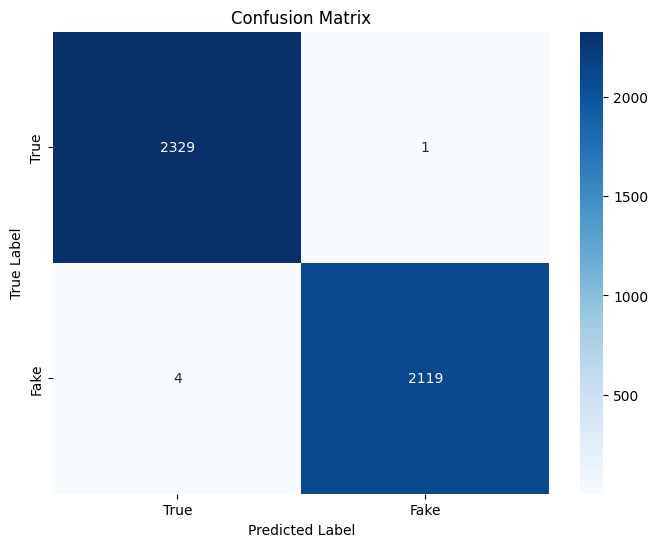

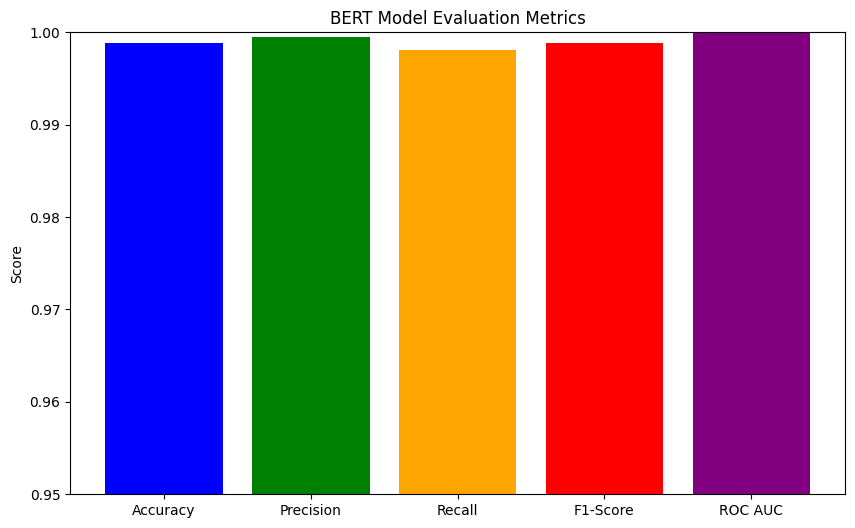

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot other metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
values = [accuracy, precision, recall, f1, roc_auc]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple'])
plt.ylim(0.95, 1.0) # Set y-axis limits for better visualization of high scores
plt.ylabel('Score')
plt.title('BERT Model Evaluation Metrics')
plt.show()

In [12]:
# Define sample fake and true news articles
sample_texts = [
    "BREAKING: Hillary Clinton arrested for espionage!", # Sample Fake
    "New study shows climate change accelerating faster than predicted.", # Sample True
    "EXCLUSIVE: Actor claiming to be Elvis spotted in rural Alabama diner.", # Sample Fake
    "Company X announces record profits for the third quarter.", # Sample True
    "URGENT: Government planning to seize all private property next week!", # Sample Fake
    "Scientists discover new species of deep-sea fish.", # Sample True
]

# Tokenize the sample texts
sample_encodings = tokenizer(sample_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Move tensors to the same device as the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sample_encodings = {key: val.to(device) for key, val in sample_encodings.items()}
model_BERT.to(device) # Ensure model is also on the correct device

# Get predictions from the trained BERT model
model_BERT.eval() # Set the model to evaluation mode
with torch.no_grad():
    sample_outputs = model_BERT(**sample_encodings)

# Get the logits and apply softmax to get probabilities
sample_logits = sample_outputs.logits
sample_probabilities = torch.softmax(sample_logits, dim=1)

# Get the predicted labels (0 for True, 1 for Fake)
predicted_labels = torch.argmax(sample_probabilities, dim=1).tolist()

# Print the results
print("Sample News Article Predictions:")
for i, text in enumerate(sample_texts):
    prediction = "Fake" if predicted_labels[i] == 1 else "True"
    probability_fake = sample_probabilities[i][1].item()
    print(f"Article: {text[:100]}...") # Print first 100 characters of the article
    print(f"Predicted Label: {prediction} (Probability of Fake: {probability_fake:.4f})")
    print("-" * 50)

Sample News Article Predictions:
Article: BREAKING: Hillary Clinton arrested for espionage!...
Predicted Label: True (Probability of Fake: 0.0025)
--------------------------------------------------
Article: New study shows climate change accelerating faster than predicted....
Predicted Label: Fake (Probability of Fake: 0.5501)
--------------------------------------------------
Article: EXCLUSIVE: Actor claiming to be Elvis spotted in rural Alabama diner....
Predicted Label: True (Probability of Fake: 0.0059)
--------------------------------------------------
Article: Company X announces record profits for the third quarter....
Predicted Label: True (Probability of Fake: 0.1300)
--------------------------------------------------
Article: URGENT: Government planning to seize all private property next week!...
Predicted Label: True (Probability of Fake: 0.0135)
--------------------------------------------------
Article: Scientists discover new species of deep-sea fish....
Predicted Label: